In [19]:
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer
import torch

base_model = "Qwen/Qwen2-0.5B-Instruct"
config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    quantization_config=config,
    num_labels=2,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

device = "cuda" if torch.cuda.is_available() else "cpu"

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2-0.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from datasets import load_dataset

def tokenize_fn(x):
    toks = tokenizer(
        x["sentence"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    toks["labels"] = x["label"]
    return toks

dataset = load_dataset("glue", "sst2", split="train") \
                .shuffle(seed=42) \
                .select(range(5000)) \
                .train_test_split(test_size=0.1, seed=42)

train = dataset['train']
val = dataset['test']

train = train.map(tokenize_fn, batched=False)
val = val.map(tokenize_fn, batched=False)

train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [21]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=[
        "q_proj", 
        "k_proj", 
        "v_proj", 
        "o_proj"
    ],
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)

In [ ]:
from transformers import TrainingArguments, Trainer 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

training_args = TrainingArguments(
    output_dir="qwen2-sst2-lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=2,
    learning_rate=2e-4,
    logging_steps=8,
    fp16=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
)
trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
8,0.986100
16,1.164100
24,0.978300
32,0.773800
40,0.741200
48,0.620500
56,0.744600
64,0.627300
72,0.642300
80,0.457800


TrainOutput(global_step=1126, training_loss=0.2987022817293662, metrics={'train_runtime': 2427.7748, 'train_samples_per_second': 3.707, 'train_steps_per_second': 0.464, 'total_flos': 9925163089920000.0, 'train_loss': 0.2987022817293662, 'epoch': 2.0})

In [41]:
from torch.utils.data import DataLoader
val_loader = DataLoader(
    val,
    batch_size=1,                      
    shuffle=False
)

model = model.to(device)
model.eval()
model.config.pad_token_id = tokenizer.pad_token_id

total = correct = 0

for i, batch in enumerate(val_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    preds = torch.argmax(outputs.logits, dim=-1)

    correct += (preds == labels).sum().item()
    total += labels.size(0)

In [42]:
print(f"Accuracy: {correct / total}")

Accuracy: 0.898


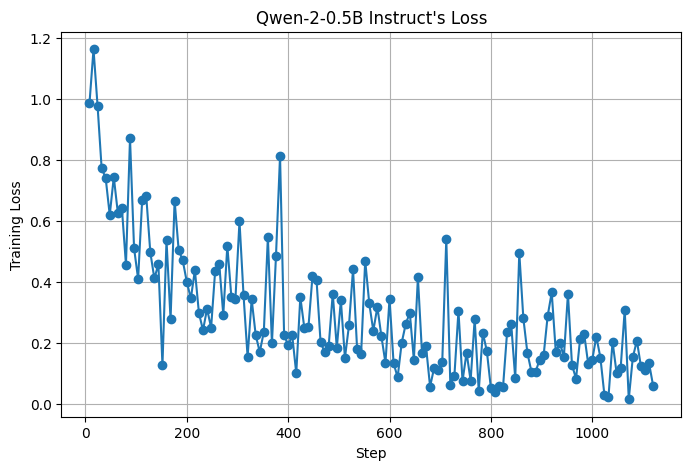

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history

loss_records = [entry for entry in logs if "loss" in entry]

df = pd.DataFrame({
    "step":   [entry["step"]   for entry in loss_records],
    "loss":   [entry["loss"]   for entry in loss_records],
})

plt.figure(figsize=(8, 5))
plt.plot(df["step"], df["loss"], marker="o", linestyle="-")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Qwen-2-0.5B Instruct's Loss")
plt.grid(True)
plt.show()
